In [89]:
from torch.utils.data import Dataset, DataLoader
import librosa
import matplotlib.pyplot as plt
from PIL import Image
import time

In [3]:
from src.datasets import *
from src.visualization import *

## Problem Definition

## Dataset
LIBRISPEECH
LibriSpeech is a corpus of approximately 1000 hours of 16kHz read English speech, prepared by Vassil Panayotov with the assistance of Daniel Povey. The data is derived from read audiobooks from the LibriVox project, and has been carefully segmented and aligned.

Section contents:
- Visualize random sample
- Calculate dataset statistics

In [4]:
dataset_name = "librispeech"
dataset = get_dataset(dataset_name)

You're about to download librispeech with url dev-clean

 Done downloading


#### Visualizing data in random sample

waveform:  tensor([[-0.0002, -0.0015, -0.0017,  ...,  0.0003,  0.0004,  0.0002]])
sample_rate:  16000
transcript:  THEY WERE NOT ONLY GOOD CHRISTIANS AND FAITHFUL TO THE CHURCH BUT EVEN REAL DEVOTEES AND FULL OF SCRUPLES
speaker_id:  3170


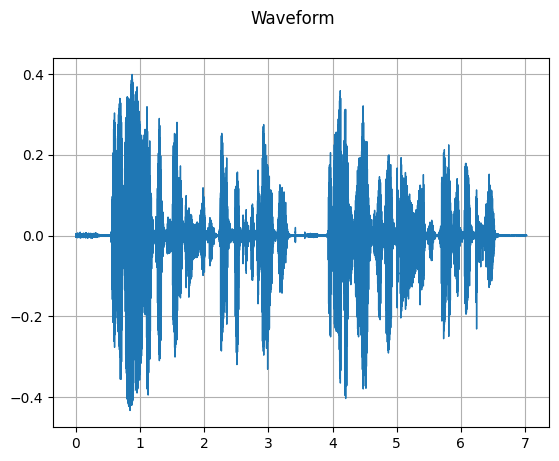

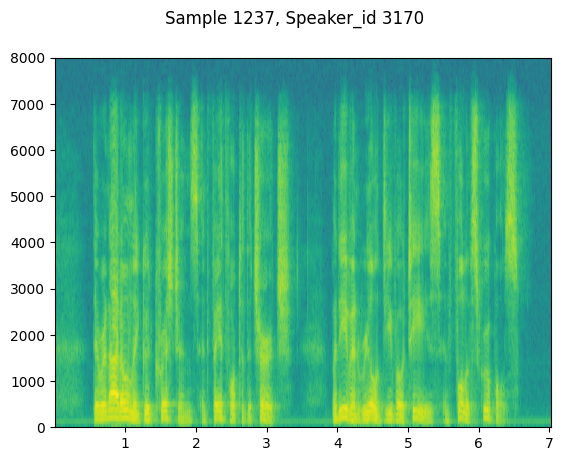

In [5]:
visualize_random_sample(dataset, plot_wave=True, plot_spectogram=True)

#### Calculate statistics in dataset

In [6]:
import pandas as pd
import numpy as np

In [7]:
waveform_lengths = []
sample_rates = []
transcript_lengths = []
speaker_ids = []
audio_durations = []    

for i in range(dataset.__len__()):
    (waveform, sample_rate, transcript, speaker_id, chapter_id, utterance_id) = dataset.__getitem__(i)
    waveform_lengths.append(waveform[0].shape[0])
    sample_rates.append(sample_rate)
    transcript_lengths.append(len(transcript))
    speaker_ids.append(speaker_id)

    num_channels, num_frames = waveform.shape
    duration = num_frames / sample_rate
    audio_durations.append(duration)

dataset_stats = pd.DataFrame.from_dict(
{
    "waveform_lengths" : waveform_lengths,
    "sample_rates" : sample_rates,
    "transcript_lengths" : transcript_lengths,
    "audio_durations" : audio_durations,
}
    )

In [8]:
df_spkr = pd.DataFrame(columns=['speaker_id', 'duration'])
df_spkr['speaker_id'] = speaker_ids
df_spkr['duration'] = audio_durations

Because on average the duration of each speaker is 4.8 or higher, we decided to use a window_size of 4 seconds. Samples shorter than 4 seconds will be removed from the dataset

In [30]:
df_spkr.groupby('speaker_id').mean().sort_values(by='duration', ascending=True)

,duration
speaker_id,
3752,4.788218
2277,5.057843
6313,5.105885
1462,5.129628
3081,5.335724
2428,5.528563
5694,5.790181
777,5.898658
5895,6.016188


Number of samples for each speaker

In [120]:
df_spkr.groupby('speaker_id').size().sort_values()

speaker_id
422      36
2902     38
3576     41
1673     42
3000     47
3170     49
2078     52
6319     55
2086     55
8842     55
2803     57
3853     57
1993     58
2412     58
174      59
5536     59
5338     59
1919     64
3536     64
84       65
652      71
7850     72
1272     73
6295     74
1988     75
8297     75
251      75
6345     77
2035     77
6241     78
7976     78
5895     80
777      82
5694     83
2428     87
3081     90
1462     94
2277     95
6313     96
3752    101
dtype: int64

Dataset has 2703 samples
Random samples has shape: torch.Size([1, 93680])
Unique speaker ids: 40


,waveform_lengths,sample_rates,transcript_lengths,audio_durations
min,23120.0,16000.0,3.0,1.0
std,75130.0,0.0,74.0,5.0
min,23120.0,16000.0,3.0,1.0
max,522320.0,16000.0,516.0,33.0


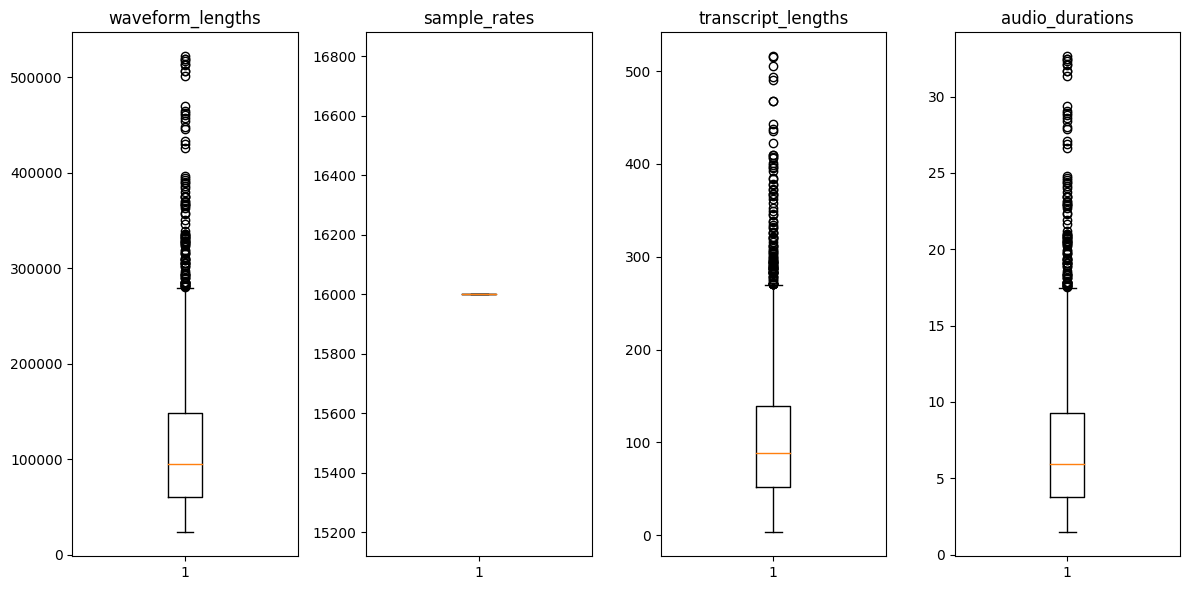

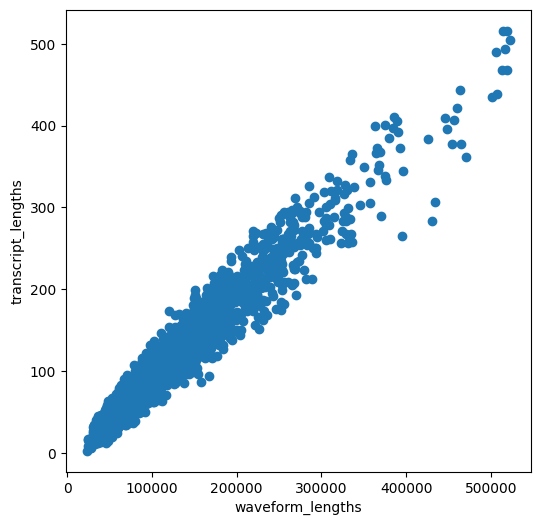

In [121]:
df = calculate_statistics(dataset)

## Preprocessing

In [9]:
def split_waveform(waveform : np.array, window_size : int) -> list[np.array]:
    """
    Takes an original waveform and reduce to chunks of smaller intervals using a sliding window
    
    waveform : nd.array
    
    window_size : int
        window size in seconds
    
    Returns
    -------
    splitted_waveform : list[nd.array]
        list of waverforms
    
    """
    splitted_waveform = []
    
    for i in range(0, len(waveform), window_size):
        split = waveform[i:i+window_size]
        if len(split) == window_size:
            splitted_waveform.append(split)

    return splitted_waveform

In [10]:
sample_rate = 16000 # 16kHz
window_size = 4 * sample_rate # 1 second has 16000 samples, window_size is 4 seconds

batch_size = 10

We decided to normalize our data by using the mean and variance of the amplitude. The normalizer is fitted on the whole training set, not for each speaker. The reasoning for this is that in our problem, we do not know ahead of time who the speaker is.

In [11]:
from sklearn.model_selection import train_test_split

In [16]:
TRAIN_PCT = 0.70
VAL_PCT = 0.20
TEST_PCT = 0.10

In [15]:
TRAIN_PCT + VAL_PCT + TEST_PCT

0.9999999999999999

In [93]:
class MFCCData(Dataset):
    def __init__(self, dataset, window_size : int, sample_rate : int, train_val_test : str, transform):
        """
        Creates a dataset of spectrograms from a dataset of waveforms
        
        train_test_val : str
            one of 'train', 'validation', or 'test'
        """
        self.dataset = dataset
        self.window_size = window_size        
        self.sample_rate = sample_rate
        self.train_val_test = train_val_test
        self.transform = transform
        self.transform_to_mfcc()
        self.split_train_test_val()

    def transform_to_mfcc(self):
        """
        Transforms waveforms into MFCC spectrograms
        """
        
        self.waveform_speaker_pairs = []
        
        for i in range(self.dataset.__len__()):
            (waveform, sample_rate, transcript, speaker_id, chapter_id, utterance_id) = dataset.__getitem__(i)
            waveform_arr = waveform.numpy().flatten()
            splitted_waveform = split_waveform(waveform_arr, self.window_size)
            
            for chunk in splitted_waveform:
                mfccs = librosa.feature.mfcc(y=chunk.flatten(), n_mfcc=13, sr=self.sample_rate)
                self.waveform_speaker_pairs.append([mfccs, speaker_id])
            
    def split_train_test_val(self):
        x = np.asarray(self.waveform_speaker_pairs)[:,0]
        y = np.asarray(self.waveform_speaker_pairs)[:,1]
        x_train, x_val_test, y_train, y_val_test = train_test_split(x, y, test_size=VAL_PCT+TEST_PCT, train_size=TRAIN_PCT, shuffle=True)
        x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size=TEST_PCT/(VAL_PCT+TEST_PCT), train_size=VAL_PCT/(VAL_PCT+TEST_PCT), shuffle=True)
        
        if self.train_val_test == 'train':
                self.waveform_speaker_pairs = [[x_train[i], y_train[i]] for i in range(len(x_train))]
        elif self.train_val_test == 'validation':
                self.waveform_speaker_pairs = [[x_val[i], y_val[i]] for i in range(len(x_val))]
        elif self.train_val_test == 'test':
                self.waveform_speaker_pairs = [[x_test[i], y_test[i]] for i in range(len(x_test))]
            
    def __len__(self):
        return len(self.waveform_speaker_pairs)

    def __getitem__(self, idx):
        waveform = self.waveform_speaker_pairs[idx][0]
                
        if self.transform is not None:
            waveform_img = Image.fromarray(waveform, mode = 'RGB')
            waveform = self.transform(waveform_img)
        speaker_id = self.waveform_speaker_pairs[idx][1]
        return waveform, speaker_id

In [21]:
def normalize_data(mfcc_dataset_train):
    columns = [f"x_{i}" for i in range(number_spectral_coeffients)]
    df_coeffs = pd.DataFrame(columns=columns)

    mfcc_mean = []
    mfcc_std = []

    j = 0
    for mfcc, _ in mfcc_dataset_train:
        for i in range(number_spectral_coeffients):
            df_coeffs.loc[j, f"x_{i}"] = mfcc[i,:]
        j += 1

    for i in range(number_spectral_coeffients):
        mfcc_mean.append(np.mean(np.hstack(df_coeffs[f"x_{i}"])))
        mfcc_std.append(np.std(np.hstack(df_coeffs[f"x_{i}"])))
    
    return mfcc_mean, mfcc_std

In [82]:
custom_transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor()])

In [94]:
mfcc_dataset_train = MFCCData(dataset, window_size=window_size, sample_rate=sample_rate, train_val_test='train', transform=custom_transform)
mfcc_dataset_val = MFCCData(dataset, window_size=window_size, sample_rate=sample_rate, train_val_test='validation', transform=custom_transform)
mfcc_dataset_test = MFCCData(dataset, window_size=window_size, sample_rate=sample_rate, train_val_test='test', transform=custom_transform)

/var/folders/lw/2w4krq7j17j90d3zrj46d4hc0000gn/T/ipykernel_46263/1460453632.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asarray(self.waveform_speaker_pairs)[:,0]
/var/folders/lw/2w4krq7j17j90d3zrj46d4hc0000gn/T/ipykernel_46263/1460453632.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y = np.asarray(self.waveform_speaker_pairs)[:,1]


In [95]:
mfcc_dataset_train.__len__(), mfcc_dataset_val.__len__(), mfcc_dataset_test.__len__(),

(2399, 686, 343)

Normalize the data

In [165]:
for mfcc, speaker_id in train_loader:
    print(speaker_id)
    break

tensor([2412, 1988, 6319, 2428, 3000, 6319,  422, 1919,  251, 1993])


In [24]:
mfcc_mean, mfcc_std = normalize_data(mfcc_dataset_train)
mfcc_dataset_train.waveform_speaker_pairs = np.array(mfcc_dataset_train.waveform_speaker_pairs)
for sample in mfcc_dataset_train.waveform_speaker_pairs:
    for i in range(13):
        sample[0][i,:] = (sample[0][i,:] - mfcc_mean[i]) / mfcc_std[i]

NameError: name 'number_spectral_coeffients' is not defined

In [115]:
from collections import Counter

#dataset = torchvision.datasets.CIFAR10(root=os.getcwd(), download=True, transform=ToTensor())
idx_to_class = {v:k for k, v in dataset.class_to_idx.items()}  # Index to class mapping

idx_distribution = dict(Counter(dataset.targets))
class_distribution = {idx_to_class[k]:v for k, v in idx_distribution.items()}

print(class_distribution)

AttributeError: 'LIBRISPEECH' object has no attribute 'class_to_idx'

In [109]:
train_loader = DataLoader(mfcc_dataset_train, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader( mfcc_dataset_val, batch_size=batch_size, shuffle=True)

In [97]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

num_epochs = 2
for epoch in range(num_epochs):

    for batch_idx, (x, y) in enumerate(train_loader):
        
        print('Epoch:', epoch+1, end='')
        print(' | Batch index:', batch_idx, end='')
        print(' | Batch size:', y.size()[0])
        
        x = x.to(device)
        y = y.to(device)

Epoch: 1 | Batch index: 0 | Batch size: 10
Epoch: 1 | Batch index: 1 | Batch size: 10
Epoch: 1 | Batch index: 2 | Batch size: 10
Epoch: 1 | Batch index: 3 | Batch size: 10
Epoch: 1 | Batch index: 4 | Batch size: 10
Epoch: 1 | Batch index: 5 | Batch size: 10
Epoch: 1 | Batch index: 6 | Batch size: 10
Epoch: 1 | Batch index: 7 | Batch size: 10
Epoch: 1 | Batch index: 8 | Batch size: 10
Epoch: 1 | Batch index: 9 | Batch size: 10
Epoch: 1 | Batch index: 10 | Batch size: 10
Epoch: 1 | Batch index: 11 | Batch size: 10
Epoch: 1 | Batch index: 12 | Batch size: 10
Epoch: 1 | Batch index: 13 | Batch size: 10
Epoch: 1 | Batch index: 14 | Batch size: 10
Epoch: 1 | Batch index: 15 | Batch size: 10
Epoch: 1 | Batch index: 16 | Batch size: 10
Epoch: 1 | Batch index: 17 | Batch size: 10
Epoch: 1 | Batch index: 18 | Batch size: 10
Epoch: 1 | Batch index: 19 | Batch size: 10
Epoch: 1 | Batch index: 20 | Batch size: 10
Epoch: 1 | Batch index: 21 | Batch size: 10
Epoch: 1 | Batch index: 22 | Batch size: 1

In [98]:
print(x.shape)

torch.Size([9, 3, 224, 224])


In [54]:
# Freeze model parameters
for param in alexnet.parameters():
    param.requires_grad = False

In [149]:
import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image

In [150]:
alexnet = models.alexnet(pretrained=True)
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [151]:
alexnet.classifier[6] = nn.Linear(4096, 40)
alexnet.classifier.add_module("7", nn.LogSoftmax(dim = 1))
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [152]:
summary(alexnet, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [ ]:
# Define Optimizer and Loss Function
loss_func = nn.NLLLoss()
optimizer = optim.Adam(alexnet.parameters())


def train_and_validate(model, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_loader):

            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)
            
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        # Validation - No gradient tracking needed
        with torch.no_grad():

            # Set to evaluation mode
            model.eval()

            # Validation loop
            for j, (inputs, labels) in enumerate(valid_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass - compute outputs on input data using the model
                outputs = model(inputs)

                # Compute loss
                loss = loss_criterion(outputs, labels)

                # Compute the total loss for the batch and add it to valid_loss
                valid_loss += loss.item() * inputs.size(0)

                # Calculate validation accuracy
                ret, predictions = torch.max(outputs.data, 1)
                correct_counts = predictions.eq(labels.data.view_as(predictions))

                # Convert correct_counts to float and then compute the mean
                acc = torch.mean(correct_counts.type(torch.FloatTensor))

                # Compute total accuracy in the whole batch and add to valid_acc
                valid_acc += acc.item() * inputs.size(0)

                #print("Validation Batch number: {:03d}, Validation: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))
            
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/2399 
        avg_train_acc = train_acc/2399

        # Find average training loss and training accuracy
        avg_valid_loss = valid_loss/686 
        avg_valid_acc = valid_acc/686

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch+1, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        #torch.save(model, dataset+'_model_'+str(epoch)+'.pt')
            
    return model, history

In [156]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_epochs = 5
trained_model, history = train_and_validate(alexnet, loss_func, optimizer, num_epochs)

Epoch: 1/5


IndexError: Target 1272 is out of bounds.